# Image Resconstrute

- Reference : 

1. https://arxiv.org/pdf/2111.12417v1.pdf
2. https://arxiv.org/pdf/2212.06714.pdf

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import visualkeras
import cv2
import os

In [3]:
np.random.seed(42)

# Load Dataset

In [4]:
X_DATA_PATH = "./data/gaussian/cropped/"
Y_DATA_PATH = "./data/gaussian/resized/"
NOISE_Y_DATA_PATH = "./only_noise/"

x_data_path_list = os.listdir(X_DATA_PATH)
y_data_path_list = os.listdir(Y_DATA_PATH)
y_noise_data_path_list = os.listdir(NOISE_Y_DATA_PATH)

X, y, y_noise = list(), list(), list()
for x_data_path in tqdm(x_data_path_list, desc=f'X data loading...'):   X.append(cv2.imread(X_DATA_PATH + x_data_path))
for y_data_path in tqdm(y_data_path_list, desc=f'Y data loading...'):   y.append(cv2.imread(Y_DATA_PATH + y_data_path))
for y_noise_data_path in tqdm(y_noise_data_path_list, desc=f'Y noise data loading...'):   y_noise.append(cv2.imread(NOISE_Y_DATA_PATH + y_noise_data_path))

Y noise data loading...: 100%|██████████| 5000/5000 [00:05<00:00, 969.85it/s]


In [5]:
X = np.array(X)[:,:,:,0]
y = np.array(y)[:,:,:,0]
y_noise = np.array(y_noise)[:,:,:,0]

scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y = scaler.fit_transform(y.reshape(-1, 1)).reshape(y.shape)
y_noise = scaler.fit_transform(y_noise.reshape(-1, 1)).reshape(y_noise.shape)

print(f"""X shape: {X.shape}
y shape: {y.shape}
y_noise shape: {y_noise.shape}""")

X shape: (5000, 256, 256)
y shape: (5000, 256, 256)
y_noise shape: (5000, 256, 256)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"""X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
X_test shape: {X_test.shape}
y_test shape: {y_test.shape}""")

X_train shape: (4000, 256, 256)
y_train shape: (4000, 256, 256)
X_test shape: (1000, 256, 256)
y_test shape: (1000, 256, 256)


In [7]:
_, _, y_train_noise, y_test_noise = train_test_split(y_noise, y_noise, test_size=0.2, random_state=42)
print(f"""y_train shape: {y_train_noise.shape}
y_test shape: {y_test_noise.shape}""")

y_train shape: (4000, 256, 256)
y_test shape: (1000, 256, 256)


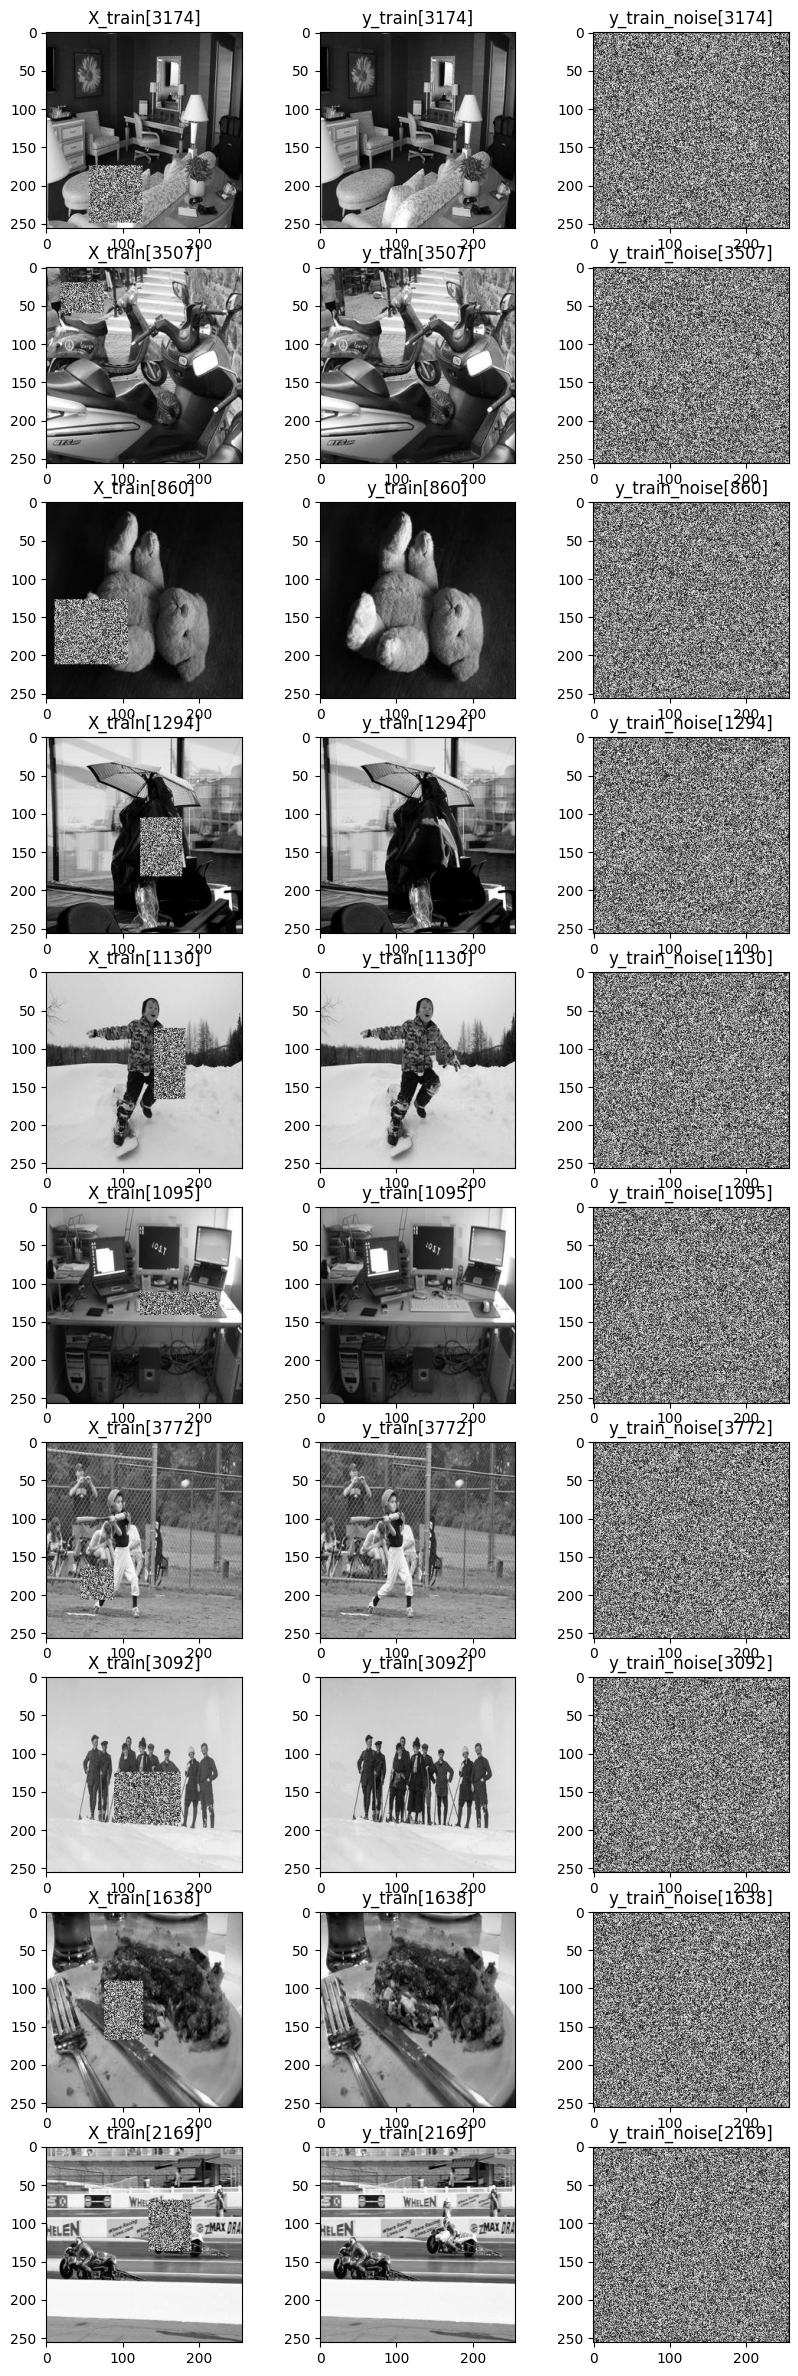

In [8]:
randlist = np.random.randint(0, X_train.shape[0], 10)

ax, fig = plt.subplots(10, 3, figsize=(10, 30))
for i, j in zip(range(10), randlist):
    fig[i][0].title.set_text(f"X_train[{j}]")
    fig[i][1].title.set_text(f"y_train[{j}]")
    fig[i][2].title.set_text(f"y_train_noise[{j}]")
    fig[i][0].imshow(X_train[j], cmap='gray')
    fig[i][1].imshow(y_train[j], cmap='gray')
    fig[i][2].imshow(y_train_noise[j], cmap='gray')
plt.show()

# Modeling

In [9]:
input_layer = layers.Input(shape=(256, 256, 1))

x1 = layers.Conv2D(16, (3, 3), strides=2, activation='gelu')(input_layer)
x1_skip2 = x1
x1 = layers.Conv2D(16, (3, 3), activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(16, (3, 3), activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)

'''First Transformer Block
----------> Start'''
x1 = layers.Conv2D(16, (3, 3), strides=2, activation='gelu')(x1)
x1_skip = layers.Conv2D(16, (3, 3), activation='gelu')(x1)
x1 = layers.DepthwiseConv2D((3, 3), strides=1, activation='gelu')(x1)
x1 = layers.Concatenate()([x1, x1])

x1 = layers.LayerNormalization()(x1)
x2 = layers.Dense(256)(x1)
x1 = layers.DepthwiseConv2D((3, 3), strides=3, activation='gelu')(x1)
x3 = layers.Dense(256)(x1)
x1 = layers.Concatenate()([x1, x3])

x1 = layers.Reshape((76, 76, 18))(x1)
x1 = layers.Conv2D(32, (2, 2), strides=3, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(32, (2, 2), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)

x1 = layers.Conv2D(32, (2, 2), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x3_skip = x1
x3_skip = layers.MaxPool2D((2, 2))(x3_skip)

## Guide 
x1 = layers.LayerNormalization()(x1)
x1 = layers.Conv2D(16, (1, 1), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.DepthwiseConv2D((3, 3), strides=1, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(16, (1, 1), strides=1, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
'''First Transformer Block
----------> End'''

# Noise Image Input
latent_space = x1
x2 = layers.Conv2DTranspose(32, (3, 3), strides=3, activation='gelu')(latent_space)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2DTranspose(32, (6, 6), strides=2, activation='gelu')(x2)
x2 = layers.BatchNormalization()(x2)

x2 = layers.Conv2DTranspose(16, (9, 9), strides=2, activation='gelu')(x2)
x2 = layers.Conv2DTranspose(16, (7, 7), strides=2, activation='gelu')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2DTranspose(16, (4, 4), activation='gelu')(x2)
x2 = layers.BatchNormalization()(x2)

x2 = layers.Conv2DTranspose(16, (5, 5), strides=2, activation='gelu')(x2)
x2 = layers.LayerNormalization()(x2)

x2 = layers.Conv2DTranspose(8, (3, 3), strides=2, activation='gelu')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2DTranspose(1, (2, 2), strides=1, activation='gelu')(x2)
x2 = layers.BatchNormalization()(x2)

x2 = layers.Reshape((256, 256, 1), name="noise_image")(x2)
y2 = x2

'''Second Transformer Block
----------> Start'''
x1 = layers.Conv2DTranspose(32, (3, 3), strides=3, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Concatenate()([x1, x3_skip])
x1 = layers.Conv2DTranspose(32, (6, 6), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)

x1 = layers.Conv2DTranspose(16, (9, 9), strides=2, activation='gelu')(x1)
x1 = layers.Conv2DTranspose(16, (7, 7), strides=2, activation='gelu')(x1)
x1 = layers.Concatenate()([x1, x1_skip])
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2DTranspose(16, (4, 4), activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)

x1 = layers.Conv2DTranspose(16, (5, 5), strides=2, activation='gelu')(x1)
x1 = layers.Concatenate()([x1, x1_skip2])
x1 = layers.LayerNormalization()(x1)

x1 = layers.Conv2DTranspose(8, (3, 3), strides=2, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2DTranspose(1, (2, 2), strides=1, activation='gelu')(x1)
x1 = layers.BatchNormalization()(x1)
'''Second Transformer Block
----------> End'''

decoded_image = layers.Reshape((256, 256, 1), name="reconstructed_image")(x1)

model = tf.keras.Model(inputs=input_layer, outputs=[decoded_image, y2])
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 125, 125, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 125, 125, 16)         64        ['conv2d_1[0][0]']            
 Normalization)  

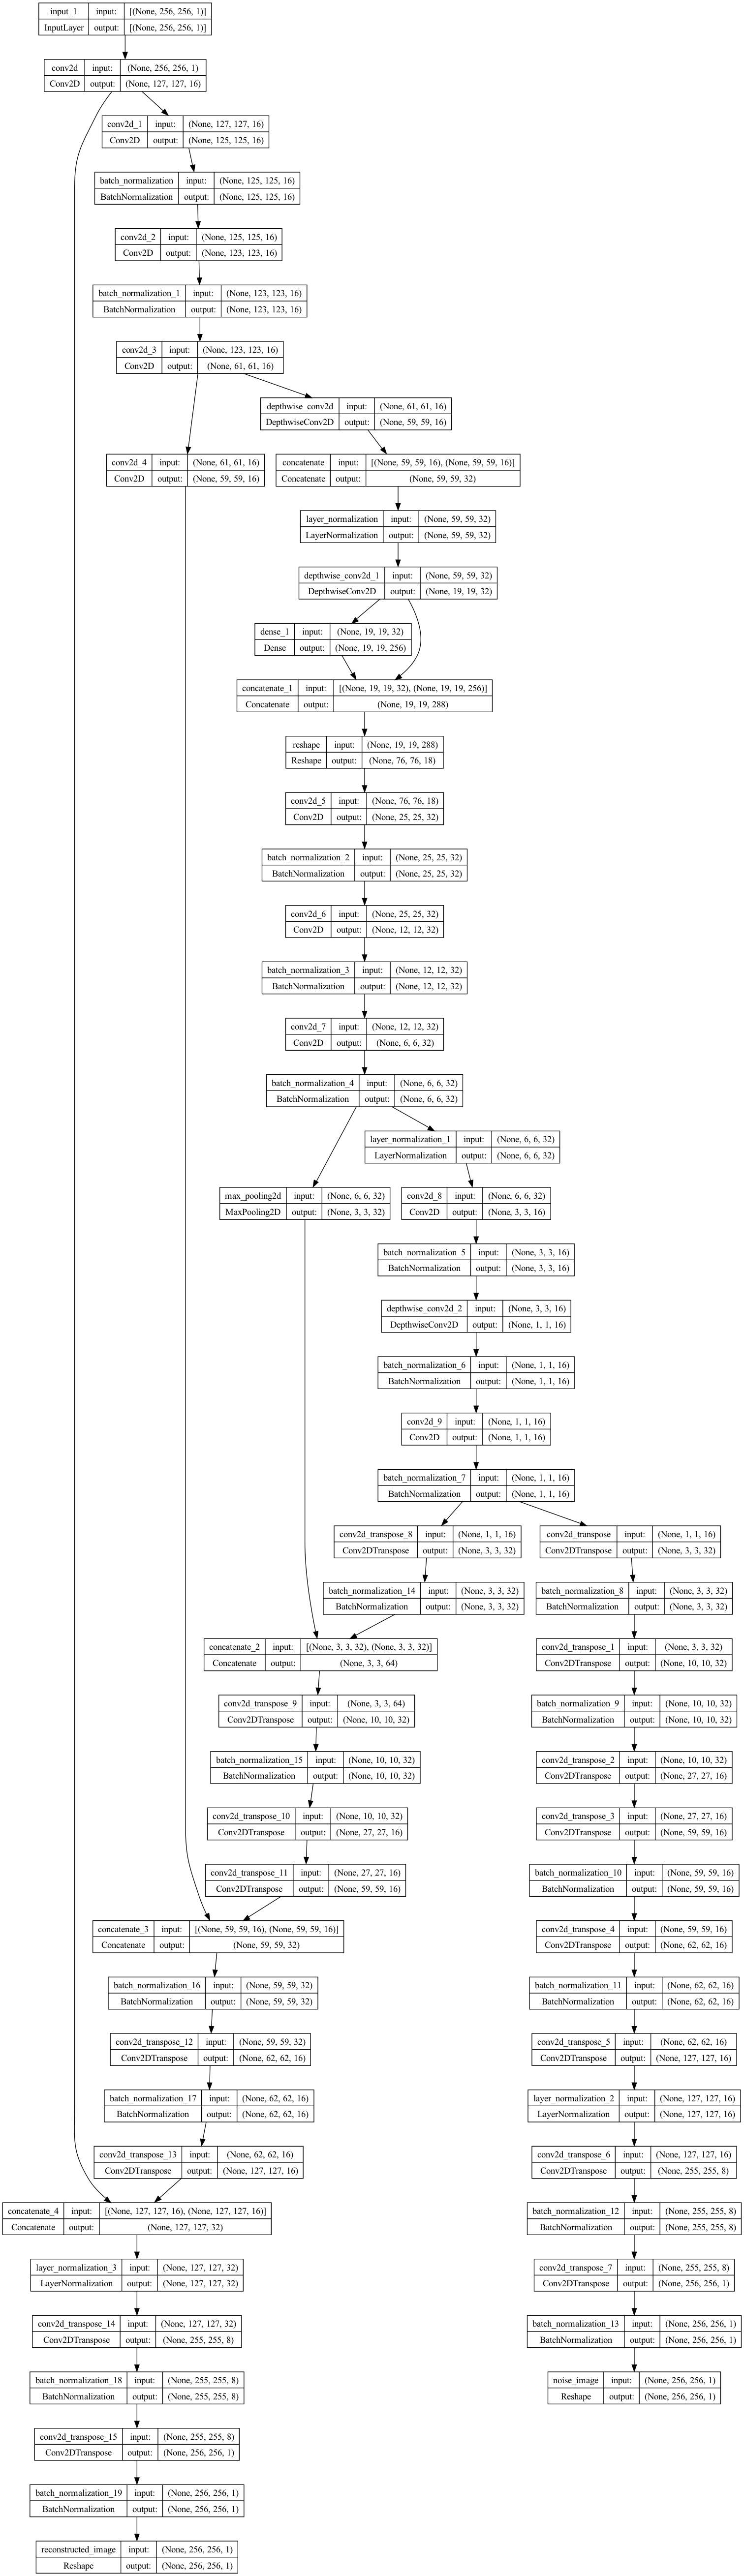

In [10]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [11]:
optimzier = tf.keras.optimizers.Adam(learning_rate=0.003)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimzier, loss=[loss, loss], metrics=['accuracy'])

# Model Training

In [12]:
outDir = './checkpoint_with_noise/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{epoch}-{val_noise_image_loss:.8f}-{val_reconstructed_image_loss:.8f}.h5'
def get_callbacks(patience = 50):
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_reconstructed_image_loss', verbose=1, save_best_only=True, period = 1)
    callbacks = [model_checkpoint]
    return callbacks

callback = get_callbacks()

In [16]:
history = model.fit(
    X_train, [y_train, y_train_noise],
    epochs=100,
    batch_size=64,
    validation_data=(X_test, [y_test, y_test_noise]),
    callbacks=[callback]
)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 8.3999 - reconstructed_image_loss: 3.4338 - noise_image_loss: 4.9662 - reconstructed_image_accuracy: 0.0124 - noise_image_accuracy: 0.0087
Epoch 1: val_reconstructed_image_loss improved from inf to 7.70055, saving model to ./checkpoint_with_noise/weights-1-5.11253500-7.70055342.h5


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 94s 1s/step - loss: 8.3999 - reconstructed_image_loss: 3.4338 - noise_image_loss: 4.9662 - reconstructed_image_accuracy: 0.0124 - noise_image_accuracy: 0.0087 - val_loss: 12.8131 - val_reconstructed_image_loss: 7.7006 - val_noise_image_loss: 5.1125 - val_reconstructed_image_accuracy: 0.0095 - val_noise_image_accuracy: 0.0081
Epoch 2/100
 8/63 [==>...........................] - ETA: 1:04 - loss: 6.6787 - reconstructed_image_loss: 2.7142 - noise_image_loss: 3.9646 - reconstructed_image_accuracy: 0.0117 - noise_image_accuracy: 0.0087

KeyboardInterrupt: 

# Result

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, 'r', label='train loss')
plt.plot(val_loss, 'b', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(20, 4))
for i in range(10):
    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(y_pred[i].reshape(256, 256))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display input image
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i].reshape(256, 256))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Model Evaluation

In [ ]:
trained_model_path = sorted(os.listdir(outDir))
pretrained_model_file = outDir + trained_model_path[-1]
print(f"pretrained_model_file: {pretrained_model_file}")

pretrained_model = keras.models.load_model(pretrained_model_file)

In [ ]:
y_pred = pretrained_model.predict(X_test)

In [ ]:
print(f"""y_pred shape: {y_pred.shape}
y_test shape: {y_test.shape}""")

In [ ]:
IMAGE_SELECT = 23

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(X_test[IMAGE_SELECT])
ax[0].set_title('Input Image')
ax[1].imshow(y_pred[IMAGE_SELECT])
ax[1].set_title('Predicted Image')
ax[2].imshow(y_test[IMAGE_SELECT])
ax[2].set_title('Ground Truth Image')
plt.show()